In [1]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",80)

# Load Training Set

To review, the training set was created by:
1. In the first notebook, we pulled hourly weather feeds for the last 7 years.  
2. In the second notebook, we created a static feature set. These are the features that overall don't change with time.  
3. Joined the weather and temporal features such as solar position with the static set and augmented the positive examples with negative examples that are very similar.  

Now that the training set has been created, we can train the model, but first we need to transform some of the variables to make it better suited for training.

In [2]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv')
df = df.dropna(how='any',axis=0)
df.shape

(2676600, 40)

In [3]:
ohe_fields=['one_way','surface_type','street_type','hour','weekday','month']

# One-Hot encode a couple of variables
df_ohe = pd.get_dummies(df,columns=ohe_fields)

# Get the one-hot variable names
ohe_feature_names = pd.get_dummies(df[ohe_fields],columns=ohe_fields).columns.tolist()
df_ohe.head()

,join_key,aadt,accident_counts,at_intersection,euclidean_length,foggy,hailing,icy,population_density,pre_dir,precip_depth,proximity_to_billboard,proximity_to_major_road,proximity_to_nearest_intersection,proximity_to_signal,raining,road_orient_approx,segment_id,segment_length,sinuosity,snow_depth,snowing,speed_limit,station_id,suf_dir,surface_width,target,temperature,thunderstorm,timestamp,visibility,wind_speed,solar_azimuth,solar_elevation,one_way_0,one_way_1,one_way_2,surface_type_,surface_type_100,surface_type_200,...,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,724700931412010-01-01T09:00:00+00:00,2582.0,2.0,1,183.940054,0.0,0.0,0.0,0.124910,S,0.0,1022.229489,0.0,3.516241,4715.299780,0.0,1.548009,21818,183.940054,1.000000,0.0,0.0,40.0,72470093141,,0,1,-7.2,0.0,2010-01-01 09:00:00+00:00,16093.0,0.0,53.133310,-64.221430,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,724700931412010-01-01T18:00:00+00:00,2608.0,11.0,0,470.656666,0.0,0.0,0.0,0.525662,S,0.0,198.159605,0.0,97.631819,1470.214192,0.0,1.728398,32209,471.394576,1.001568,0.0,0.0,65.0,72470093141,,50,1,-5.0,0.0,2010-01-01 18:00:00+00:00,16093.0,0.0,157.114449,22.926000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,724700931412010-01-02T09:00:00+00:00,6644.0,29.0,1,3445.573327,0.0,0.0,0.0,0.007127,E,0.0,817.133953,0.0,0.579181,6658.802277,0.0,3.010128,42863,3543.478498,1.028415,0.0,0.0,65.0,72470093141,,50,1,-13.3,0.0,2010-01-02 09:00:00+00:00,16093.0,0.0,52.812066,-64.224402,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,724700931412010-01-03T01:00:00+00:00,7849.0,29.0,1,1949.083740,0.0,0.0,0.0,0.000246,W,0.0,130.548630,0.0,1.294010,2704.193195,0.0,0.431349,28849,1957.032150,1.004078,0.0,0.0,65.0,72470093141,,0,1,-11.1,0.0,2010-01-03 01:00:00+00:00,16093.0,2.1,247.537151,-8.984745,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,724700931412010-01-03T15:00:00+00:00,6215.0,31.0,1,1983.762463,0.0,0.0,0.0,0.000354,E,0.0,15421.039782,0.0,3.166401,12.475764,0.0,2.192179,11320,2136.108683,1.076797,0.0,0.0,65.0,72470093141,,0,1,-8.9,0.0,2010-01-03 15:00:00+00:00,16093.0,0.0,121.156632,0.908545,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


# Continuous Features
These are currently:
* Historical Accident Count
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic, if available)
* Road Surface Width (If available)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind Speed
* Road Orientation
* Solar Azimuth
* Solar Elevation

These will be rescaled by scikit-learn's standard rescaler

In [4]:
# Sinuosity is typically close to 1, even for moderately curvy roads. A high sinuosity means a longer road.
feature_transforms = {
    'sinuosity': np.log
}
for feature,transform in feature_transforms.items():
    df_ohe[feature] = transform(df_ohe[feature])

# Continuously valued features
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed',
    'proximity_to_billboard',
    'proximity_to_major_road',
    'proximity_to_signal',
    'proximity_to_nearest_intersection',
    'population_density',
    'solar_azimuth',
    'solar_elevation',
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
#print (float_features.mean(axis=0))

df_ohe[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)


In [5]:
y = df['target'].values

binary_feature_names = [
    'snowing',
    'raining',
    'icy',
    'thunderstorm',
    'hailing',
    'foggy',
    'at_intersection',
]

df_ohe = df_ohe.xs(float_feature_names+binary_feature_names+ohe_feature_names,axis=1)

In [6]:
X = df_ohe.values
y = df['target'].values
feature_names = df_ohe.columns.tolist()

This "wrangler" object is simply a dictionary that stores our feature transforms and such. Note that if your end to end workflow was using scikit-learn, you could easily build a Pipeline to perform feature transforms and have the ability to save it off for future use. This takes a little bit more work for the simple task we are performing here.

In [7]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names,
    'feature_transforms': feature_transforms 
}
with open('wrangler_new.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

# Define Model (Gradient Boosting)

We use XGBoost to build the gradient boosting model with some hyperparameters set. You could optimize these using CV and grid search. These parameters were set to these values part through that process and through some manual fine tuning. They certainly aren't optimal, but perform well for this task. 

In [8]:
feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}

In [9]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[0]	eval-auc:0.808141
Will train until eval-auc hasn't improved in 25 rounds.
[1]	eval-auc:0.814441
[2]	eval-auc:0.81698
[3]	eval-auc:0.818965
[4]	eval-auc:0.820621
[5]	eval-auc:0.822105
[6]	eval-auc:0.822573
[7]	eval-auc:0.822679
[8]	eval-auc:0.822809
[9]	eval-auc:0.823808
[10]	eval-auc:0.8241
[11]	eval-auc:0.824486
[12]	eval-auc:0.824624
[13]	eval-auc:0.824762
[14]	eval-auc:0.825045
[15]	eval-auc:0.825082
[16]	eval-auc:0.825276
[17]	eval-auc:0.825318
[18]	eval-auc:0.825506
[19]	eval-auc:0.825561
[20]	eval-auc:0.825632
[21]	eval-auc:0.825885
[22]	eval-auc:0.826086
[23]	eval-auc:0.826098
[24]	eval-auc:0.826365
[25]	eval-auc:0.826469
[26]	eval-auc:0.826533
[27]	eval-auc:0.826579
[28]	eval-auc:0.826763
[29]	eval-auc:0.826775
[30]	eval-auc:0.826838
[31]	eval-auc:0.826793
[32]	eval-auc:0.826812
[33]	eval-auc:0.826867
[34]	eval-auc:0.826834
[35]	eval-auc:0.826818
[36]	eval-auc:0.826923
[37]	eval-auc:0.826893
[38]	eval-auc:0.826878
[39]	eval-auc:0.826892
[40]	eval-auc:0.826895
[41]	eval-auc:

In [10]:
print(fnames)

['accident_counts' 'speed_limit' 'aadt' 'surface_width' 'sinuosity'
 'euclidean_length' 'segment_length' 'road_orient_approx' 'precip_depth'
 'snow_depth' 'temperature' 'visibility' 'wind_speed'
 'proximity_to_billboard' 'proximity_to_major_road' 'proximity_to_signal'
 'proximity_to_nearest_intersection' 'population_density' 'solar_azimuth'
 'solar_elevation' 'snowing' 'raining' 'icy' 'thunderstorm' 'hailing'
 'foggy' 'at_intersection' 'one_way_0' 'one_way_1' 'one_way_2'
 'surface_type_ ' 'surface_type_100' 'surface_type_200' 'surface_type_300'
 'surface_type_DIRT' 'surface_type_IMPROVED' 'surface_type_OTHER'
 'surface_type_PAVED' 'street_type_ ' 'street_type_ALY' 'street_type_AVE'
 'street_type_BAY' 'street_type_BLVD' 'street_type_CIR' 'street_type_COR'
 'street_type_CRK' 'street_type_CT' 'street_type_CTR' 'street_type_CV'
 'street_type_CYN' 'street_type_DR' 'street_type_ESTS' 'street_type_EXPY'
 'street_type_FWY' 'street_type_HL' 'street_type_HOLW' 'street_type_HTS'
 'street_type_HWY

# Which features are most important?

The feature importance is the sum of the weights for each feature, essentially how often it is used in the boosting model. You can see the top three features are solar position and temperature. The solar az/el mostly encode time and are colinear with some other variables such as hour and month. There's also correlation between temperature and other variables. Temperature is a terrific proxy variable, because it encodes the season, time of day, and likelihood for surfaces to bit slippery/sticky. It's not in itself a predictor of accidents, but helps us encode conditions we can't easily directly observe.

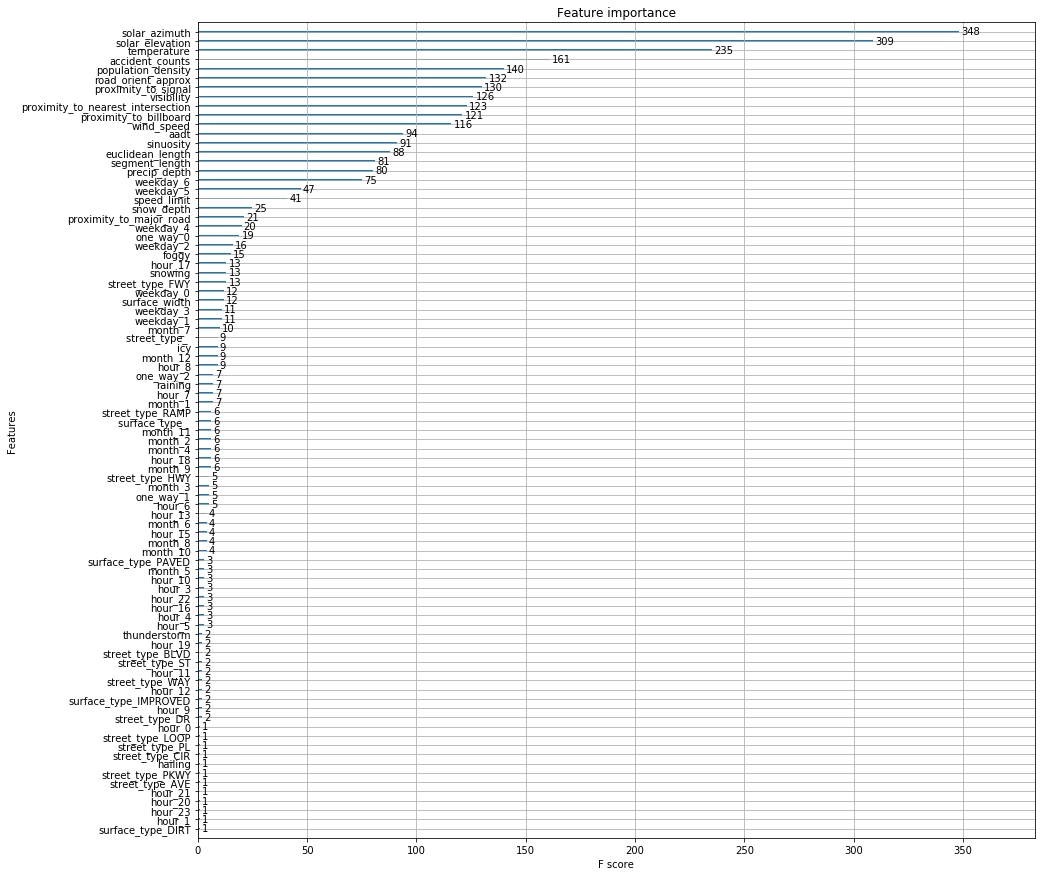

In [11]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [12]:
booster.save_model('new_0001.model')

# Model Performance

One of the best metrics for model performance is the ROC curve, which displays what the false positive rate is given a choice of true positive rate. The area under this curve was how we evaluated the performance when training.

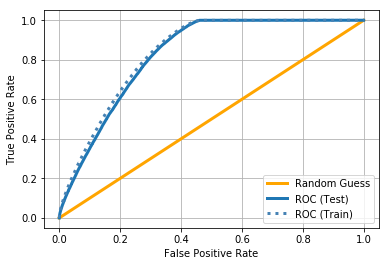

In [30]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

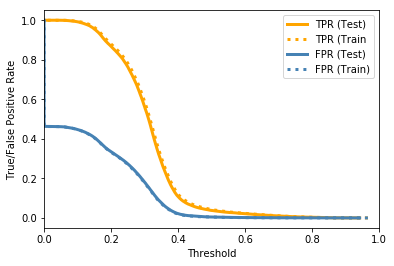

In [33]:

plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

Another good metric is the precision/recall curve, which tells us two things:
1. Precision: The fraction of the time we are correct when making a positive prediction (saying there is an accident)
2. Recall: The fraction of accidents we predict

'2.2.2'

<Figure size 1080x1080 with 0 Axes>

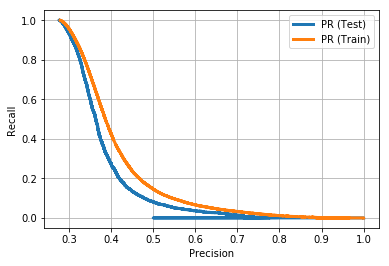

In [34]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest)
y_pred_train = booster.predict(dtrain)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

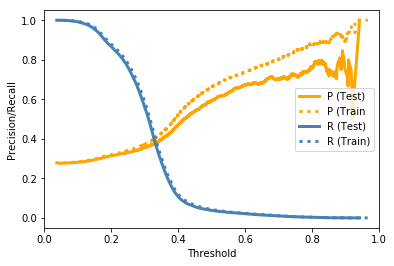

In [35]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

A particular choice of threshold (0.19) yields these results:

In [17]:
y_pred_test = booster.predict(dtest) > 0.19
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.19
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))


Test Accuracy: 0.687969812449
Test F1: 0.459835980752
Test Precision: 0.310685975477
Test Recall: 0.884413484264
Test AUC: 0.826935267681
Test AP: 0.382797422908
Train Accuracy: 0.691487542238
Train F1: 0.46788423288
Train Precision: 0.316566760292
Train Recall: 0.896322143674
Train AUC: 0.837396897179
Test AP: 0.413605435575


The split histogram is a histogram of where splits in the decision trees were made. This tells us about important areas in the feature space.

In [18]:
def plot_split_histogram(feature_name):
    hist = booster.get_split_value_histogram(feature_name)
    try:
        i = float_feature_names.index(feature_name)
        fake_data = np.zeros((hist.Count.size,len(float_feature_names)))
        fake_data[:,i] = hist.SplitValue
        hist.loc[:,'SplitValue'] = scaler.inverse_transform(fake_data)[:,i]
    except: pass
    hist.plot(kind='area',x='SplitValue',y='Count')

Note the peaks around 0 (Celsius). This indicates that this is an important differentiator in temperature. This makes sense as roads start to get icy around 0 degrees Celsius

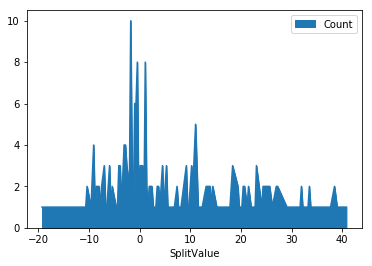

In [19]:
plot_split_histogram('temperature')

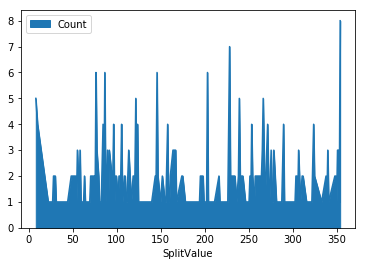

In [21]:
plot_split_histogram('solar_azimuth')

This looks more uniform, but there is a peak right around zero, when the sun is on the horizon. Perhaps this causes more accidents on east/west facing roads? It could also represent that most accidents happen during daytime, so this is a clear choice.

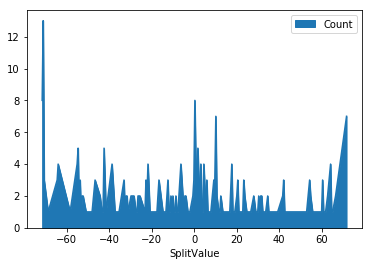

In [22]:
plot_split_histogram('solar_elevation')

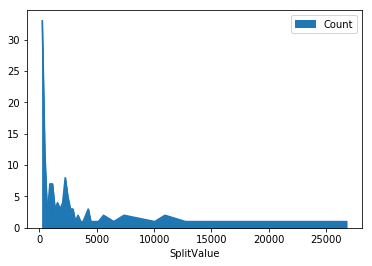

In [23]:
plot_split_histogram('proximity_to_billboard')

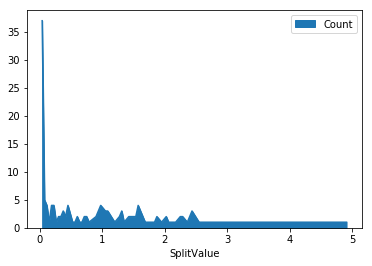

In [24]:
plot_split_histogram('population_density')

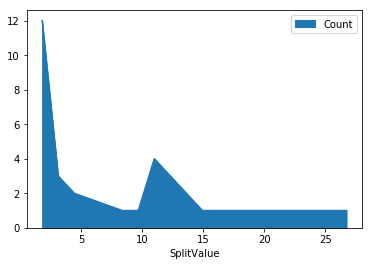

In [25]:
plot_split_histogram('snow_depth')

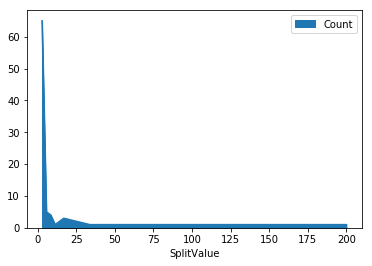

In [26]:
plot_split_histogram('precip_depth')

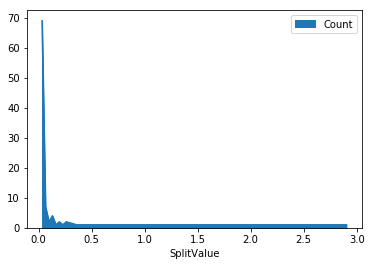

In [27]:
plot_split_histogram('sinuosity')